# Nonlinear regression: `predict` 

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [4]:
using Random
using PyCall
plt = pyimport("matplotlib.pyplot")
using PyPlot
using Printf
SkPreprocessing = pyimport("sklearn.preprocessing")
SkSVM = pyimport("sklearn.svm")
include("__init__.jl")
SkTree = pyimport("sklearn.tree")
SkEnsemble = pyimport("sklearn.ensemble")
SkNeighbors = pyimport("sklearn.neighbors")

PyObject <module 'sklearn.neighbors' from 'C:\\Users\\jasonsyc.STUDENTS.000\\.julia\\conda\\3\\lib\\site-packages\\sklearn\\neighbors\\__init__.py'>

## RBF features


Make a synthetic 1D data set.

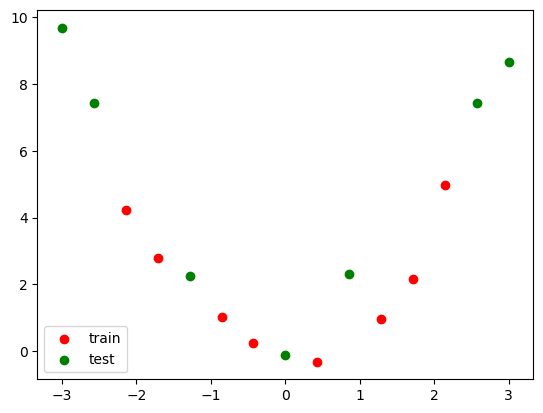

In [3]:
Random.seed!(0)

n = 15
x = range(-3,stop=3,length=n)
y = x.^2 + randn(n)

ntest = 7
ntrain = n-ntest

(xtrain,xvalid,ytrain,yvalid) = train_test_split(x,y,at=(15-7)/15)

plt.scatter(xtrain,ytrain,c=:red, label=:train);
plt.scatter(xvalid,yvalid,c=:green,label=:test);
plt.legend();

In [4]:
Xtrain = reshape(xtrain,length(xtrain),1)
Xvalid = reshape(xvalid,length(xvalid),1)

grid = reshape(range(minimum(x)-1,stop=maximum(x)+1,length=1000),1000,1);

Recall this demo from a few weeks ago, about polynomial features:

p  |  train err   | valid err |
---+--------------+-----------+
1         25.1          166.0
2          1.3            6.3
3          0.2           38.5
4          0.1           45.1
5          0.1           51.9


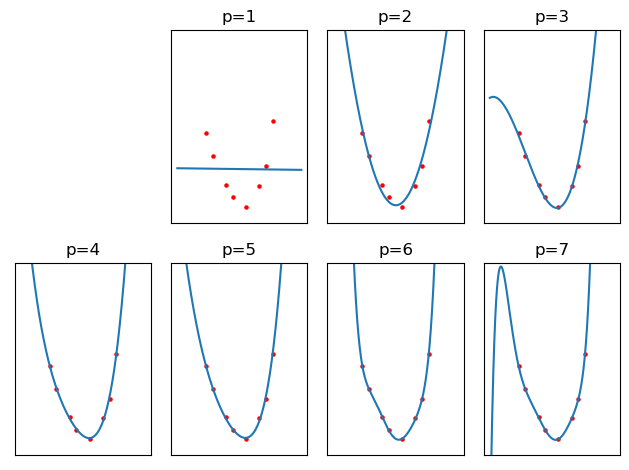

6          0.0          571.0
7          0.0          892.8


In [5]:
plt.figure()
plt.clf()

println("p  |  train err   | valid err |")
println("---+--------------+-----------+")
for p in 1:7
    pf = SkPreprocessing.PolynomialFeatures(p)
    Z = pf.fit_transform(Xtrain)
    w = Z'*Z \ Z'*ytrain # solve normal equations
    grid_poly = pf.fit_transform(grid)
    
    plt.subplot(2,4,p+1)
    plt.scatter(xtrain,ytrain,c=:red, label="train",s=5);
#     plt.scatter(xvalid,yvalid,c='green',label='test',s=5);
    plt.plot(grid, grid_poly*w)
    train_pred = Z*w
    train_err = sum((ytrain-train_pred).^2)
    valid_pred = pf.transform(Xvalid)*w
    valid_err = sum((yvalid-valid_pred).^2)
    plt.title("p=$p")
    plt.xticks(())
    plt.yticks(())
    plt.ylim((minimum(y)-1,maximum(y)+1))
    Printf.@printf("%d %12.1f   %12.1f\n", p, train_err, valid_err)
end
plt.tight_layout();
#     print(max(abs(w)))
#     print(w)

We can do the same with RBF features:

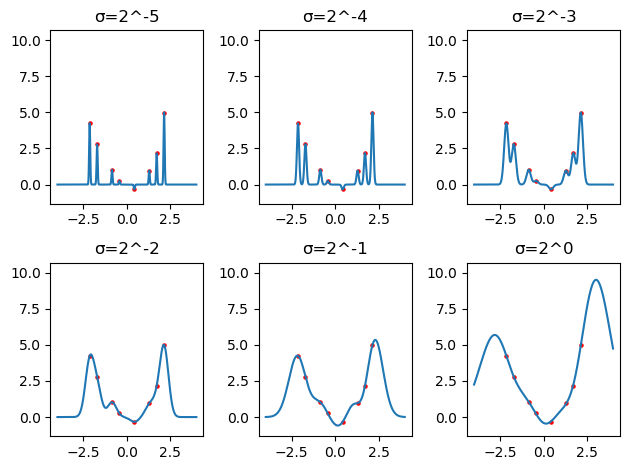

In [6]:
count = 1
for log_σ_val in -5:0
    σ_val = 2.0^log_σ_val
    Z = RBF_features(Xtrain,Xtrain,σ=σ_val)
    w = (Z'*Z + 0.000001*eye(ntrain)) \ (Z'*ytrain) # solve normal equations
    plt.subplot(2,3,count)
    plt.scatter(xtrain,ytrain,c=:red, label="train",s=5);
    grid_rbf = RBF_features(Xtrain,grid,σ=σ_val)
    plt.plot(grid, grid_rbf*w);
    plt.title("σ=2^"*string(log_σ_val))
#     plt.xticks(())
#     plt.yticks(())
    plt.ylim((minimum(y)-1,maximum(y)+1))
    count += 1
end
plt.tight_layout();

## Multiple choice question

There many be more than one (or none) that are true.

With the standard RBF basis...

1. You create one feature per training example.
2. If we have $t$ test examples, the test feature matrix $\tilde{Z}$ is $t \times t$.
3. The training matrix $Z$ is a symmetric matrix. 
4. Larger $\sigma$ means lower training error.

### RBF + regularization

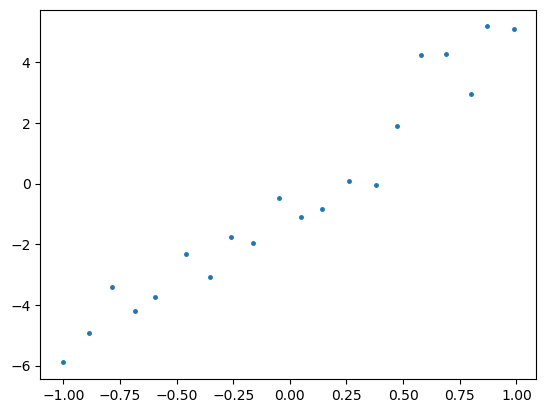

In [7]:
N = 20
X = range(-1,stop=1,length=N)+randn(N).*0.01
X=reshape(X,N,1)
y = randn(N,1) + X.*5

grid = reshape(range(minimum(X),stop=maximum(X),length=1000),1000,1)


plt.plot(X,y,".",markersize=5);

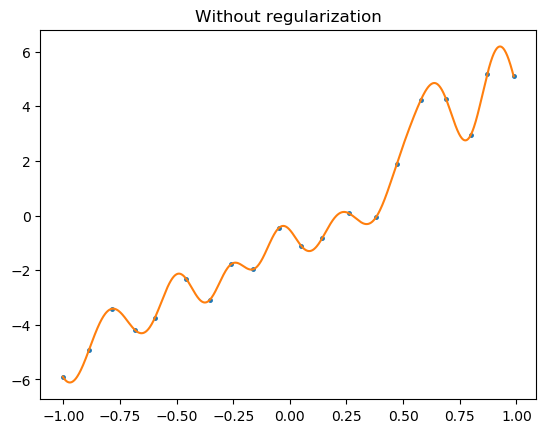

In [8]:
Z = RBF_features(X,X,σ=0.1)

v = (Z'*Z)\(Z'*y)

plt.plot(X,y,".",markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF*v);
plt.title("Without regularization");

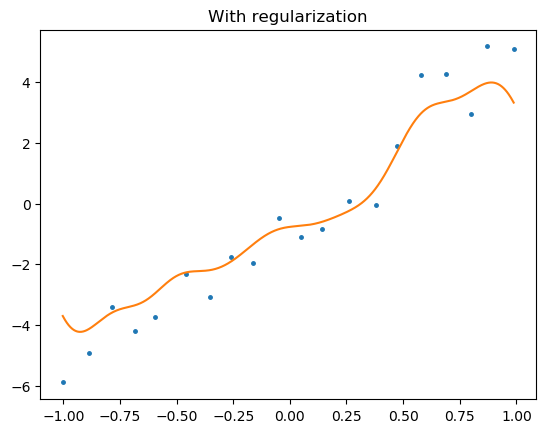

In [9]:
Z = RBF_features(X,X,σ=0.1)

λ=1
v = (Z'*Z + λ*eye(size(Z)[2])) \ (Z'*y)

plt.plot(X,y,".",markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF*v);
plt.title("With regularization");

### Back to linear classifiers: non-separable data and change of basis

- Can we use linear classifiers for nonlinear boundaries?
- Answer: yes, like we used linear regression with change-of-basis.

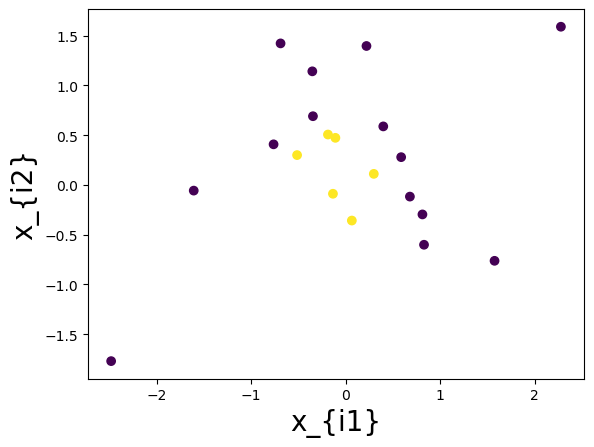

In [10]:
n = 20
d = 2
Random.seed!(0)
X = randn(n,d)
y = convert(Array{Int64},X.^2*ones(d,1) .< 0.4).+1

plt.scatter(X[:,1], X[:,2], c=y[:])
plt.xlabel("x_{i1}", fontsize=20);
plt.ylabel("x_{i2}", fontsize=20);

- The above is not linearly separable.

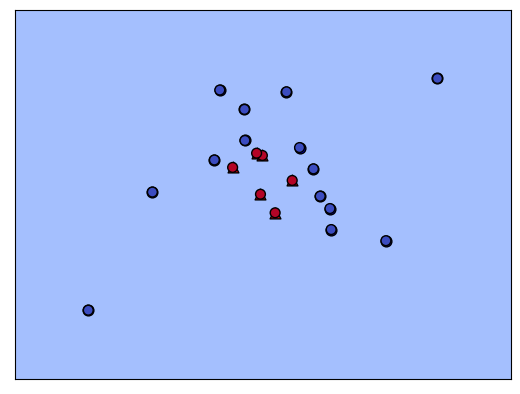

Training accuracy 0.700000

C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
svm = SkSVM.SVC(kernel="linear")
svm.fit(X,y)

plot_classifier(X,y[:],svm)

Printf.@printf("Training accuracy %f", svm.score(X,y))

Above: we can't perfectly classify all the points with a linear boundary.

But what if we transform the features as follows:

$$z_{i1} = x_{i1}^2$$
$$z_{i2} = x_{i2}^2$$

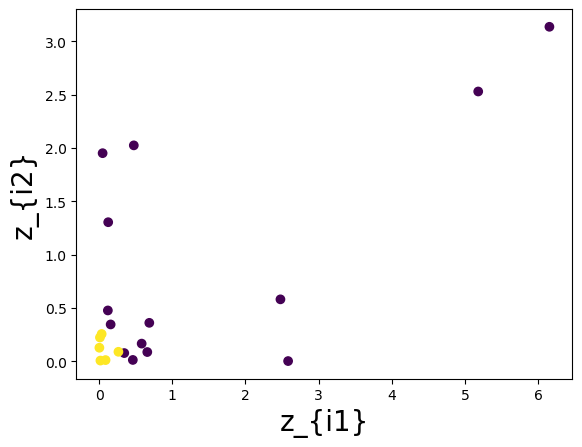

In [12]:
Z = X.^2

plt.scatter(Z[:,1], Z[:,2], c=y[:]);
plt.xlabel("z_{i1}", fontsize=20);
plt.ylabel("z_{i2}", fontsize=20);

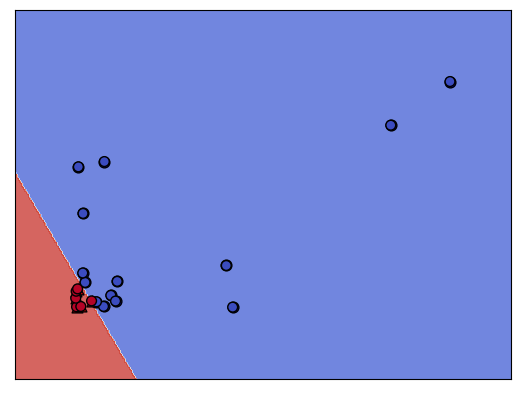

Training accuracy 0.950000

C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
svm = SkSVM.SVC(kernel="linear", C=100)
svm.fit(Z,y)

plot_classifier(Z,y[:],svm)

Printf.@printf("Training accuracy %f", svm.score(Z,y))

What does this linear boundary in $Z$-space correspond to _in the original ($X$) space_?

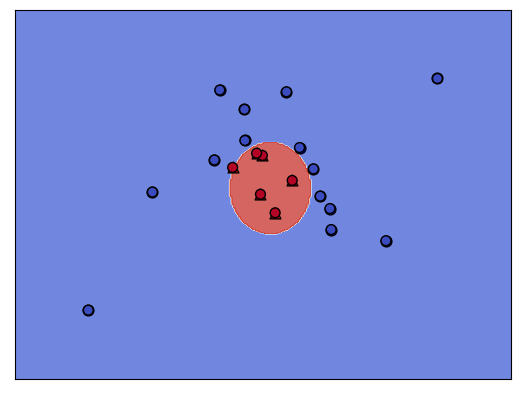

In [14]:
plot_classifier(X, y[:], svm, transformation=X-> X.^2);

It's an ellipse!

In [15]:
svm.coef_

PyObject array([[-10.81495212,  -7.50057711]])

### RBF SVM hyperparameters $\sigma$ and $\lambda$

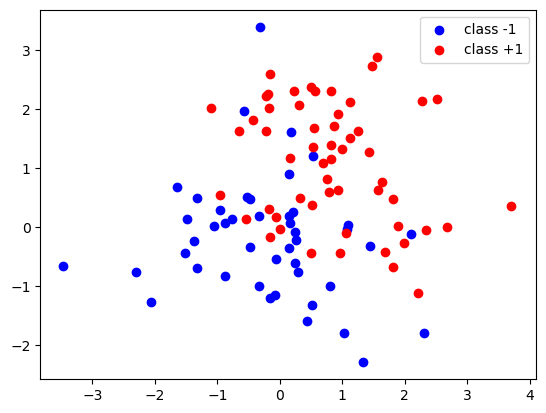

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [16]:
# generate synthetic 2D data set
n = 100
X = randn(n,2)
y = rand([-1,+1],n)
X[y.>0,:] .+= 1

plt.scatter(X[y.<0,1], X[y.<0,2], color="b", label="class -1")
plt.scatter(X[y.>0,1], X[y.>0,2], color="r", label="class +1")
plt.legend(loc="best")
plt.show()

Below:

- Larger `gamma` leads to more complex boundaries; in our notation, this hyperparameter is $\frac{1}{\sigma}$. 
- Larger `C` means less regularization; in our notation, this hyperparameter is $\frac{1}{\lambda}$.

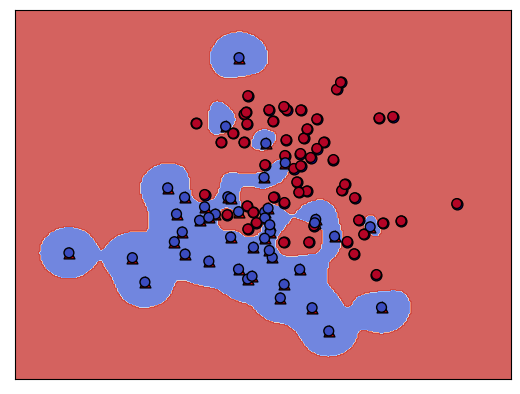

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000299DAFD0>

In [17]:
svm = SkSVM.SVC(kernel="rbf", gamma=10, C=10)
svm.fit(X,y)
plot_classifier(X, y[:], svm)

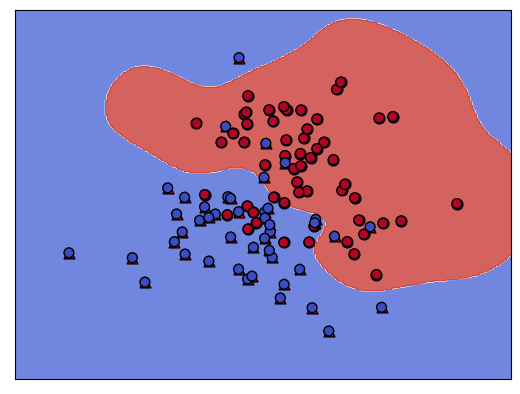

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000298A9EB8>

In [18]:
svm = SkSVM.SVC(kernel="rbf", gamma=1, C=10) # larger length scale (sigma)
svm.fit(X,y)
plot_classifier(X, y[:], svm)

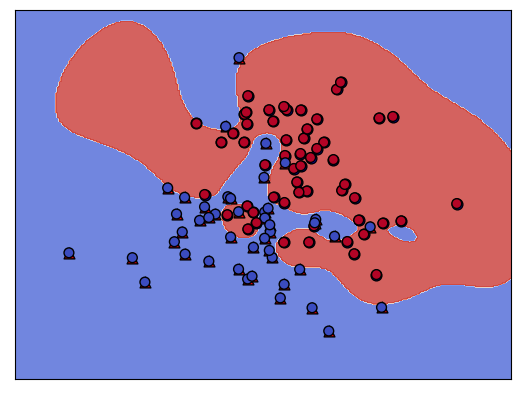

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000029850D68>

In [19]:
svm = SkSVM.SVC(kernel="rbf", gamma=1, C=1000) # less regularization
svm.fit(X,y)
plot_classifier(X, y[:], svm)

You can think of `gamma` (or $\sigma$) as controlling the abruptness at which we can change the class, whereas `C` (or $\lambda$) controls how much we worry about making errors.

### The interaction between hyperparameters

- What makes hyperparameter optimization difficult?
- Can't we just tune them one at a time?

In [24]:
sigma_min = -3
sigma_max = 3
lambda_min = -3
lambda_max = 1
sigma_grid = 10.0.^(sigma_min:sigma_max)
lambda_grid = 10.0.^(lambda_min:lambda_max)
train_errors = zeros(length(sigma_grid),length(lambda_grid))
valid_errors = zeros(length(sigma_grid),length(lambda_grid))

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

for (i,σ) in enumerate(sigma_grid)
    for (j,λ) in enumerate(lambda_grid)
        svm = SkSVM.SVC(kernel="rbf", gamma=1/σ, C=1/λ)
        svm.fit(X_train, y_train)
        train_errors[i,j] = 1-svm.score(X_train,y_train)
        valid_errors[i,j] = 1-svm.score(X_valid,y_valid)
    end
end

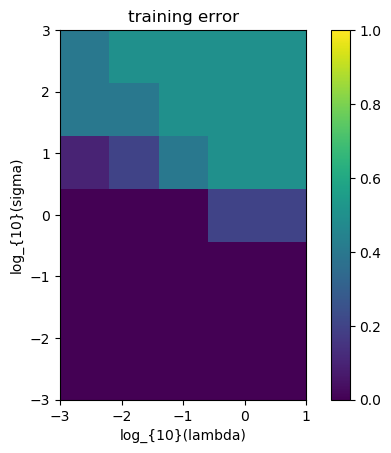

In [25]:
plt.imshow(train_errors,origin="lower",vmin=0,vmax=1,extent=(lambda_min,lambda_max,sigma_min,sigma_max))
plt.ylabel("log_{10}(sigma)")
plt.xlabel("log_{10}(lambda)")
plt.title("training error")
plt.colorbar();

Above: as expected, we get the best training error with the least regularization and the smallest $\sigma$.

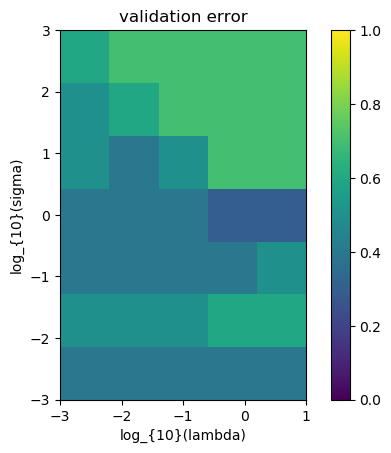

In [26]:
plt.imshow(valid_errors,origin="lower",vmin=0,vmax=1,extent=(lambda_min,lambda_max,sigma_min,sigma_max))
plt.ylabel("log_{10}(sigma)")
plt.xlabel("log_{10}(lambda)")
plt.title("validation error")
plt.colorbar();

- However, the situation changes for validation error. 
- Furthermore, the hyerparameters interact with each other
  - If we set $\sigma=1$ and optimized $\lambda$, we'd get something non-optimal.

### What is regularization actually doing? (Bonus, to read over later)

- It seems like `gamma` (or $\sigma$) matters more than `C` (or $\lambda$)
- The effect of `C` (or $\lambda$) is somewhat subtle

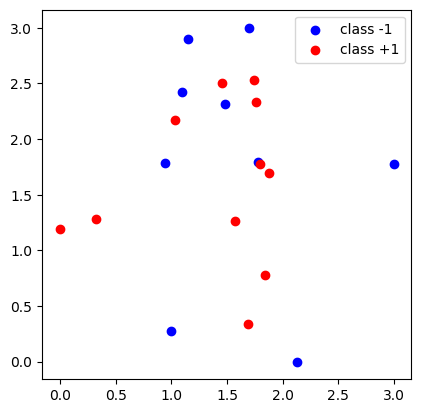

In [12]:
# generate synthetic 2D data set
Random.seed!(1)
n = 20
X = randn(n,2)
X .-= [minimum(X[:,i]) for i in 1:2]'
X ./= [maximum(X[:,i]) for i in 1:2]'
X .*= 3
y = rand([-1,+1],n)

plt.scatter(X[y.<0,1], X[y.<0,2], color="b", label="class -1")
plt.scatter(X[y.>0,1], X[y.>0,2], color="r", label="class +1")
plt.legend(loc="best")
plt.axis("equal");
plt.axis("square");

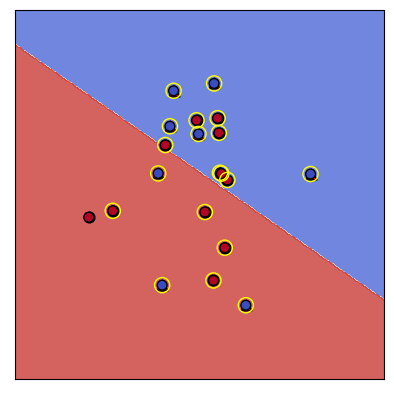

In [13]:
svm = SkSVM.SVC(kernel="linear", C=10)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis("equal");
plt.axis("square");

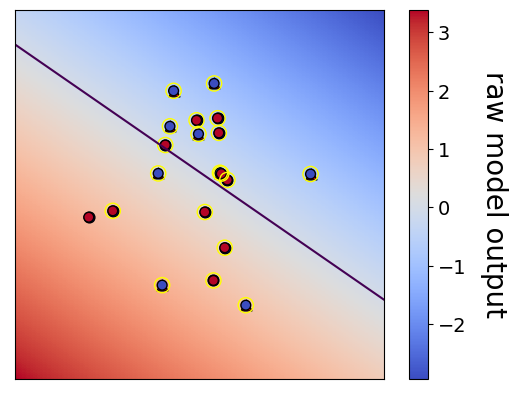

In [14]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw")
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);

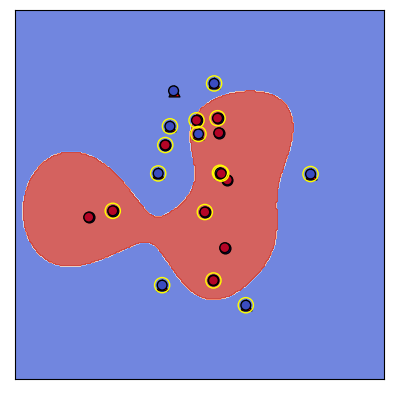

In [26]:
svm = SkSVM.SVC(kernel="rbf", gamma=1, C=10)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis("equal");
plt.axis("square");

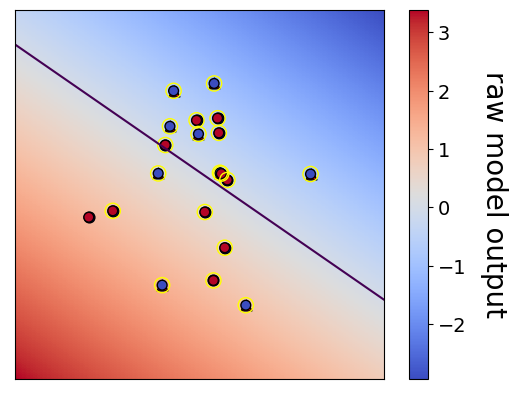

In [15]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw")
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);

We'd expect more regularization to correspond to simpler models, meaning that if we increase the regularization strength we might be able to get rid of one of the "islands" of red. 

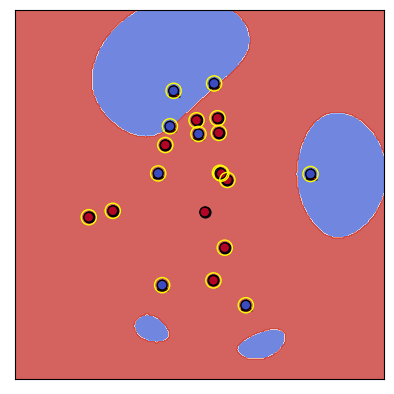

In [28]:
svm = SkSVM.SVC(kernel="rbf", gamma=1, C=0.7)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120); 
plt.axis("equal");
plt.axis("square");

Above: by increasing the regularization, we got two of the red "islands" to disappear from the classification surface. But since those red points are still support vectors (yellow circles), they are still affecting the raw model output, as shown below.

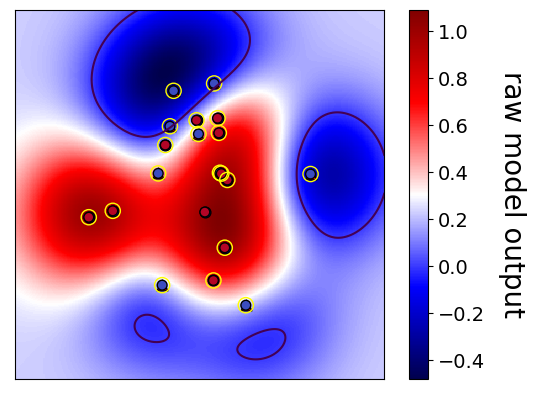

In [29]:
plot_classifier(X, y, svm, ax=plt.gca(), proba="raw") 
plt.scatter(svm.support_vectors_[:,1],svm.support_vectors_[:,2], marker="o", edgecolor="yellow", facecolor="none", s=120);

Note: if you look carefully at the colours and colourbar, you'll see that something is a support vector if it's blue and the raw model output is above $-1$ or if it's red and the raw model output is below $1$.

### Adapting Counting & Distance-based methods for regression (bonus)

We can adapt our classification methods to perform regression.

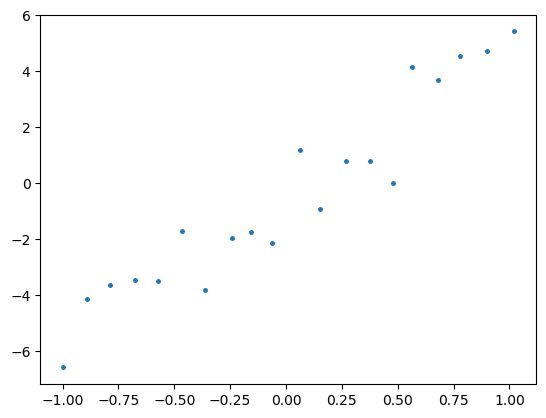

In [194]:
N = 20
X = range(-1,stop=1,length=N)+randn(N).*0.01
X=reshape(X,N,1)
y = randn(N,1) + X.*5

grid = reshape(range(minimum(X),stop=maximum(X),length=1000),1000,1)


plt.plot(X,y,".",markersize=5);

#### Decision tree regression

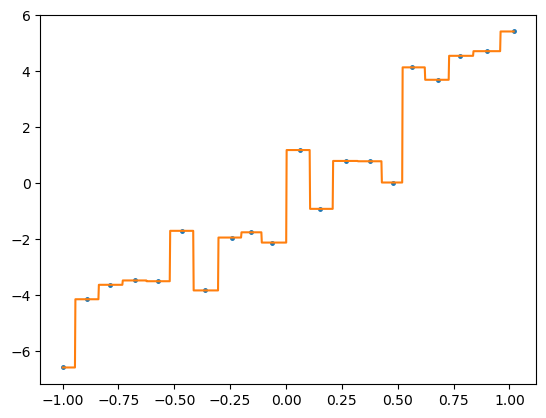

In [196]:
dtr = SkTree.DecisionTreeRegressor()
dtr.fit(X,y)
plt.plot(X,y,".",markersize=5);
plt.plot(grid, dtr.predict(grid));

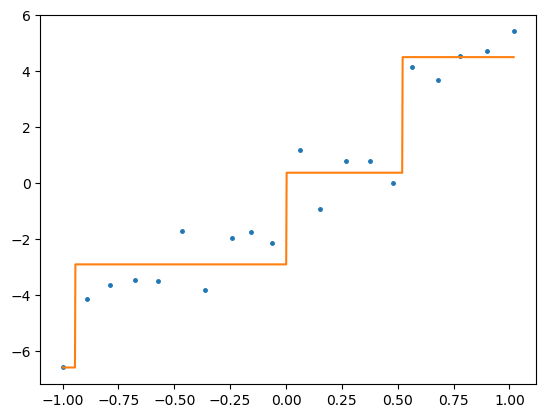

In [203]:
dtr = SkTree.DecisionTreeRegressor(max_depth=2)
dtr.fit(X,y)
plt.plot(X,y,".",markersize=5);
plt.plot(grid, dtr.predict(grid));

#### Random forest regression

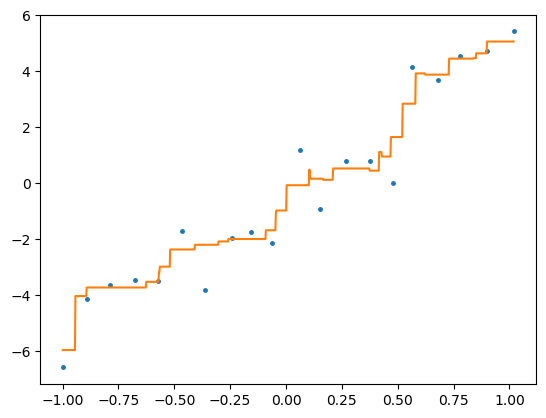

In [210]:
rfr = SkEnsemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(X,y[:])
plt.plot(X,y,".",markersize=5);
plt.plot(grid, rfr.predict(grid));

#### KNN regression

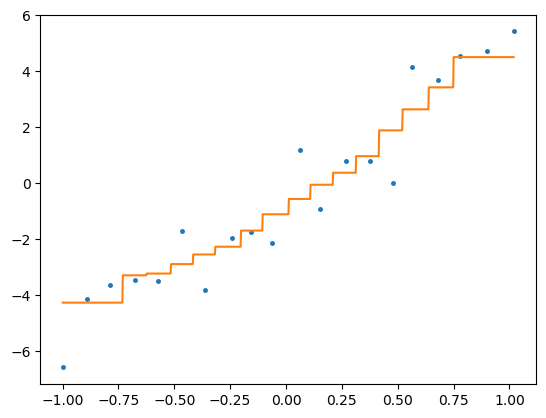

In [214]:
knnr = SkNeighbors.KNeighborsRegressor(n_neighbors=5, weights="uniform")
knnr.fit(X,y)
plt.plot(X,y,".",markersize=5);
plt.plot(grid, knnr.predict(grid));

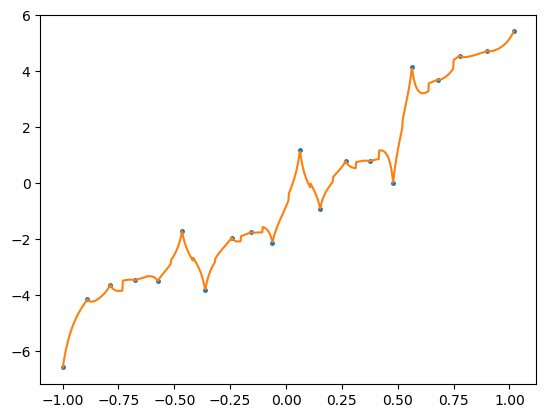

In [216]:
knnr = SkNeighbors.KNeighborsRegressor(n_neighbors=5, weights="distance")
knnr.fit(X,y)
plt.plot(X,y,".",markersize=5);
plt.plot(grid, knnr.predict(grid));

Other possible approaches:

- Regression tree with linear regression at leaves.
- Probabilistic models, i.e. fit $p(x_i\mid y)$ and $p(y)$ with a Gaussian or other model.
- "Locally linear regression": for each $x_i$, fit a linear model weighted by distance. 
- Ensembles of these.

# Summary

- RBF features are a flexible nonparametric basis.
  - Expensive at test time, needs to loop through all training examples. 
- Change of basis can be used for linear classifiers as well (not just regression).
  - Can turn a non-separable dataset into a separable one.
  - The ideas from regression carry over.
- Hyperparameter search
  - It's a pain, hard to avoid.
  - Becoming more automated over time.
- Tree/KNN regression
  - Popular and effective regression models.
  